In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Add country names to country adjacency matrix:

In [2]:
country_names = pd.read_csv('../Data/RefugeeCountries.csv', header=None, names=['Country'])
country_adjacency = pd.read_csv('../Data/CountryAdjacencyNew.csv', header=None, names=country_names.Country)
country_adjacency.set_index(country_names.Country, inplace=True)
country_adjacency.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua & Barbuda,Argentina,Armenia,Aruba,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.000000,0.194824,0.162125,0.302638,0.188657,0.197613,0.183679,0.270109,0.187870,0.176989,...,0.229307,0.224730,0.164466,0.346503,0.209408,0.001721,0.105437,0.096744,0.050228,0.087366
Albania,0.194824,1.000000,0.183806,0.320041,0.210086,0.207531,0.193200,0.356705,0.186814,0.145093,...,0.247949,0.300284,0.158705,0.352849,0.279810,0.040401,0.135001,0.119562,0.062622,0.091750
Algeria,0.162125,0.183806,1.000000,0.317953,0.198119,0.279262,0.257833,0.312734,0.120059,0.227639,...,0.315922,0.257013,0.071457,0.416702,0.239489,0.071801,0.781080,0.604456,0.094293,0.123463
Andorra,0.302638,0.320041,0.317953,1.000000,0.554197,0.419065,0.393426,0.883240,0.175027,0.387938,...,0.515396,0.749842,0.126136,0.736060,0.698716,0.034239,0.187976,0.178803,0.087243,0.185271
Angola,0.188657,0.210086,0.198119,0.554197,1.000000,0.255873,0.243022,0.559057,0.109277,0.239017,...,0.316639,0.475218,0.089660,0.443647,0.442816,0.023624,0.123280,0.115468,0.053687,0.113123


In [3]:
country_adjacency.shape

(214, 214)

In [4]:
country_adjacency.Netherlands.sort_values(ascending=False).head(10)

Country
Nigeria                1.0
Madagascar             1.0
Marshall Islands       1.0
Malta                  1.0
Comoros                1.0
Congo - Brazzaville    1.0
Cook Islands           1.0
Malawi                 1.0
Costa Rica             1.0
Latvia                 1.0
Name: Netherlands, dtype: float64

Create graph of language similarity between countries:

In [5]:
G = nx.from_pandas_adjacency(country_adjacency.T)
G.name = 'Language similarity between countries'
print(nx.info(G))

Name: Language similarity between countries
Type: Graph
Number of nodes: 214
Number of edges: 23002
Average degree: 214.9720


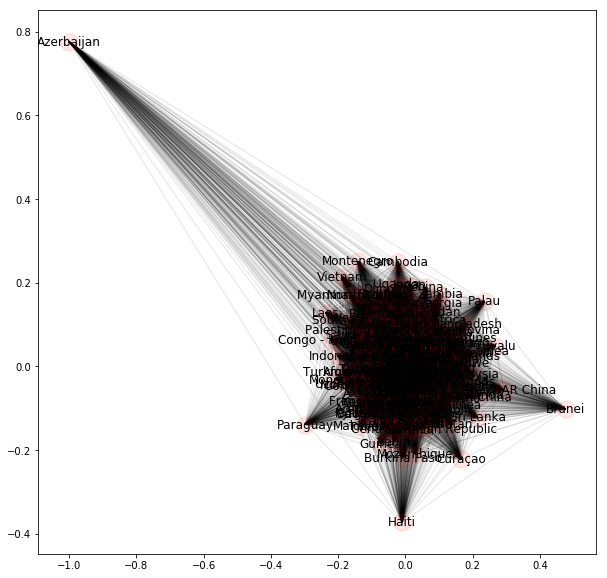

In [6]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.show()

Read one year of refugee data, rows denote country of asylum, columns denote country of origin.

In [7]:
refugee_data_folder = '../Data/RefugeeMatrices/'
refugee_2016 = pd.read_csv(refugee_data_folder + 'RefugeeAdjacency2016.csv', 
                           header=None, names=country_names.Country, dtype=int)
refugee_2016.set_index(country_names.Country, inplace=True)
refugee_2016.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua & Barbuda,Argentina,Armenia,Aruba,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Albania,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
Algeria,2,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,90000,5,0,0
Andorra,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Angola,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18,0,7,0


In [8]:
refugee_2016.shape

(214, 214)

Convert refugee adjacency matrix to percentage refugees of origin country:

In [9]:
refugee_2016 = refugee_2016.div(refugee_2016.sum(axis=0), axis=1)
refugee_2016.fillna(0, inplace=True)
refugee_2016.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua & Barbuda,Argentina,Armenia,Aruba,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000e+00,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Albania,0.000000e+00,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000107,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Algeria,8.035223e-07,0.0,0.00000,0.0,0.000035,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.992764,0.000052,0.000000,0.0
Andorra,0.000000e+00,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Angola,0.000000e+00,0.0,0.00026,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000199,0.000000,0.004645,0.0


Create directed graph with networkx from adjacency df.
Transpose df because networkx uses rows as source nodes and columns as target nodes.
Remove nodes that have less refugees than certain threshold and create two graphs of language similarity and refugees.

In [10]:
threshold = 0.9
refugee_2016_masked = refugee_2016.mask(refugee_2016 < threshold, 0)

In [11]:
G2016 = nx.from_pandas_adjacency(refugee_2016_masked.T, create_using=nx.DiGraph())
G2016.name = 'Refugee 2016'
print(nx.info(G2016))

Name: Refugee 2016
Type: DiGraph
Number of nodes: 214
Number of edges: 26
Average in degree:   0.1215
Average out degree:   0.1215


In [12]:
nodes_to_remove = list(nx.isolates(G2016))
G2016.remove_nodes_from(nodes_to_remove)
print(nx.info(G2016))

Name: Refugee 2016
Type: DiGraph
Number of nodes: 40
Number of edges: 26
Average in degree:   0.6500
Average out degree:   0.6500


In [13]:
G.remove_nodes_from(nodes_to_remove)
print(nx.info(G))

Name: Language similarity between countries
Type: Graph
Number of nodes: 40
Number of edges: 820
Average degree:  41.0000


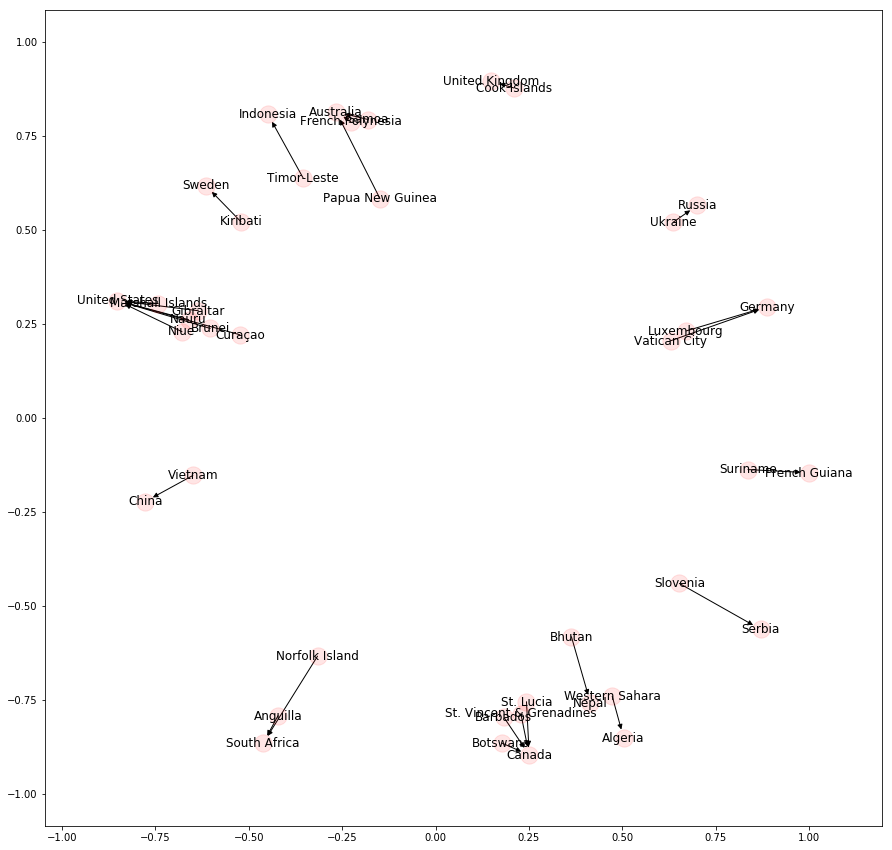

In [14]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G2016)
nx.draw_networkx_nodes(G2016, pos, alpha=0.1)
nx.draw_networkx_labels(G2016, pos)
nx.draw_networkx_edges(G2016, pos)
plt.show()

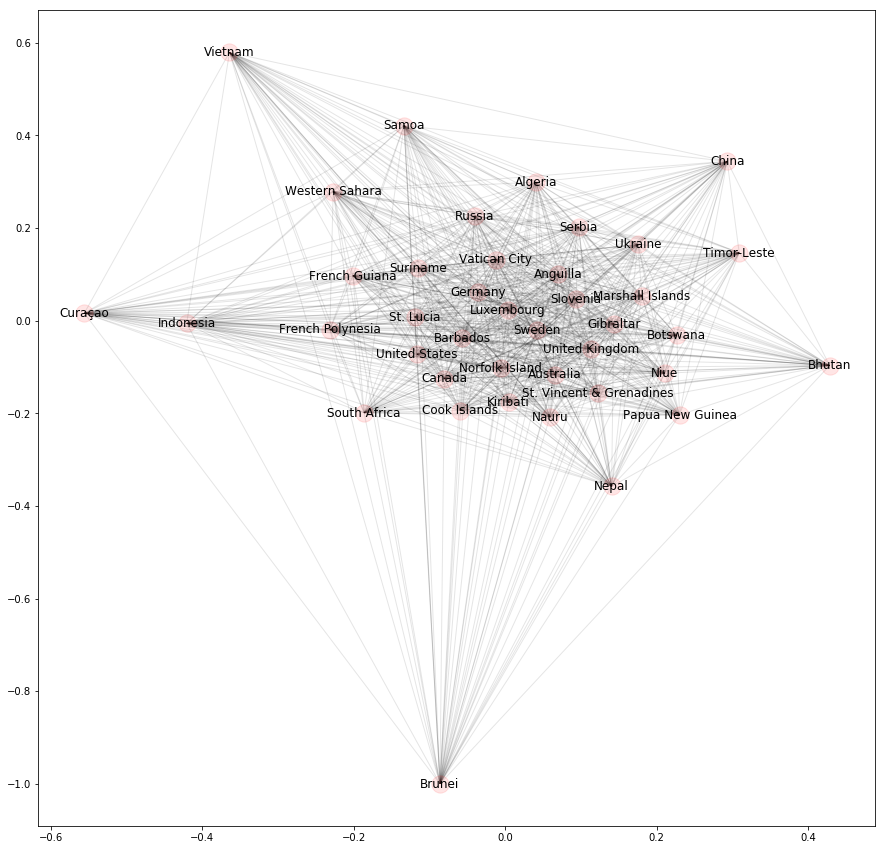

In [15]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.show()